<a href="https://colab.research.google.com/github/MilaPotanina/ML/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%80%D0%B0%D1%81%D1%85%D0%BE%D0%B4%D0%BE%D0%B2_%D0%B7%D0%B0_%D0%BE%D1%82%D0%BA%D0%B0%D0%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd

# Загрузка данных
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

# Просмотр структуры данных
print(df_train.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276205 entries, 0 to 276204
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       276205 non-null  int64  
 1   order_id                         276205 non-null  object 
 2   departure_country                276205 non-null  int64  
 3   departure_city                   269885 non-null  float64
 4   departure_region                 276205 non-null  int64  
 5   arrival_country                  276205 non-null  int64  
 6   arrival_city                     267342 non-null  float64
 7   arrival_region                   276205 non-null  int64  
 8   order_date                       276205 non-null  object 
 9   stock_departure_date             276205 non-null  object 
 10  delivery_service_departure_date  276205 non-null  object 
 11  client_arrival_date              276205 non-null  object 
 12  it

In [50]:
#посмотрим на основные метрики
print(df_train.describe())

          Unnamed: 0  departure_country  departure_city  departure_region  \
count  276205.000000      276205.000000   269885.000000     276205.000000   
mean   138102.000000          11.829728      232.526139        934.976499   
std     79733.659888           1.206116      175.040157        523.889072   
min         0.000000           1.000000        0.000000          0.000000   
25%     69051.000000          12.000000      121.000000        452.000000   
50%    138102.000000          12.000000      125.000000        856.000000   
75%    207153.000000          12.000000      352.000000       1405.000000   
max    276204.000000          13.000000      714.000000       1755.000000   

       arrival_country   arrival_city  arrival_region      item_type  \
count    276205.000000  267342.000000   276205.000000  276205.000000   
mean         11.753010     252.725737      937.165033       0.099861   
std           1.591248     183.106162      521.315965       0.358597   
min           1.00

In [51]:
#посмотрим на отсутствующие данные и постараемся их заполнить
df_train.isnull().sum()


,0
Unnamed: 0,0
order_id,0
departure_country,0
departure_city,6320
departure_region,0
arrival_country,0
arrival_city,8863
arrival_region,0
order_date,0
stock_departure_date,0


In [52]:
# Удаляем столбцы Unnamed: 0, order_id - потому что они не будут влиять на модель, и client_keywords - потому что слишком много данных пропущено
columns_to_drop = ['Unnamed: 0', 'order_id', 'client_keywords']
df_train.drop(columns=columns_to_drop, inplace=True)
df_test.drop(columns=columns_to_drop, inplace=True)





In [53]:
# Заменяем пропущенные значения в 'departure_city' и 'arrival_city' на моду
for col in ['departure_city', 'arrival_city', 'item_category', 'brand_name', 'delivery_service_name', 'item_package_type', 'item_id']:
    mode_value = df_train[col].mode()[0]  # Вычисляем моду
    df_train.fillna({col:mode_value}, inplace=True)
    df_test.fillna({col:mode_value}, inplace=True)



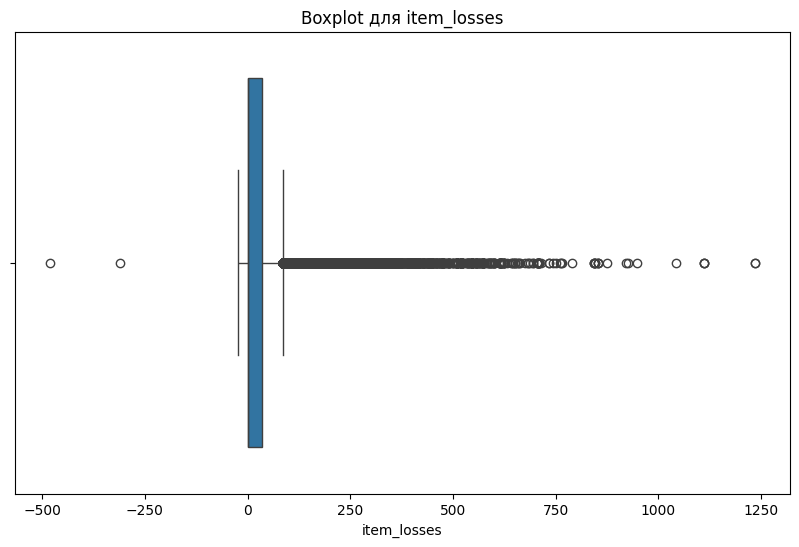

In [54]:
#посмотрим, есть ли выбросы в целевой переменной, и попробуем их заменить на медиану
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train['item_losses'])
plt.title('Boxplot для item_losses')
plt.show()



По графику видно, что у целевой перемнной имеются как крайне низкие, так и крайне высокие значения. Их необходимо нормализировать

In [59]:
# Количество строк, где значения меньше 0
count_less_than_0 = (df_train['item_losses'] < 0).sum()

# Количество строк, где значения больше 750
count_greater_than_700 = (df_train['item_losses'] > 700).sum()

# Общая сумма строк, не соответствующих диапазону
total_outliers = count_less_than_0 + count_greater_than_750

# Вывод результатов
print(f"Количество значений меньше 0: {count_less_than_0}")
print(f"Количество значений больше 700: {count_greater_than_750}")
print(f"Общее количество выбросов: {total_outliers}")


Количество значений меньше 0: 4
Количество значений больше 700: 195
Общее количество выбросов: 199


In [60]:
# эти данные можно удалить. Фильтрация значений item_losses
df_train = df_train[(df_train['item_losses'] >= 0) & (df_train['item_losses'] <= 750)]


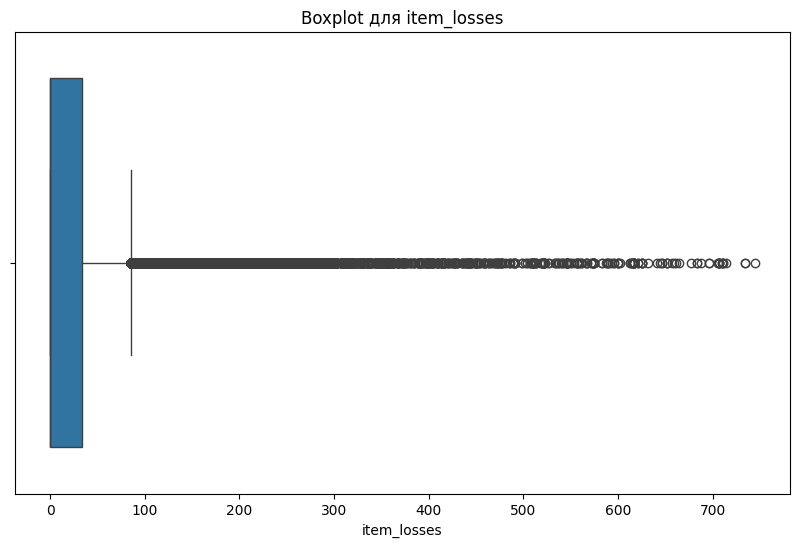

In [61]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train['item_losses'])
plt.title('Boxplot для item_losses')
plt.show()

Для того чтобы понять, какие категориальные признаки необходимо преобразовать, посмотрим на корреляцию этих признаков с целевой переменной

In [62]:
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Список категориальных признаков
categorical_columns = ['item_package_type', 'brand_name',	'item_id',	'item_category',	'delivery_service_name']

# Словарь для хранения результатов
results = {}

# Проходим по каждому категориальному признаку
for col in categorical_columns:
    # Кодируем признак во временный числовой формат
    le = LabelEncoder()
    encoded_column = le.fit_transform(df_train[col])

    # Группировка по категориям и расчет средних значений
    category_means = df_train.groupby(col)['item_losses'].mean()


    # Сохраняем результаты
    results[col] = {'mean_diff': category_means.max() - category_means.min()}

# Конвертируем результаты в DataFrame для анализа
results_df = pd.DataFrame(results).T
print(results_df)


                        mean_diff
item_package_type       17.743205
brand_name              53.581153
item_id                146.478504
item_category           44.586848
delivery_service_name  109.173845


Наибольшую корреляцию с целевой переменной имеют признаки delivery_service_name, item_id и brand_name. Их будем преобразовывать в числовые признаки, остальные удалим (здесь желательно провести анализ на важность признаков после обучения модели)

In [63]:
low_corr_features = ['item_category', 'item_package_type']  # Список столбцов с низкой корреляцией
df_train.drop(columns=low_corr_features, inplace=True)
df_test.drop(columns=low_corr_features, inplace=True)

In [64]:
#преобразуем категориальные переменные
from sklearn.preprocessing import OrdinalEncoder

# Указываем категориальные признаки
cat_features = ['delivery_service_name', 'item_id', 'brand_name']

# Создаем экземпляр OrdinalEncoder с обработкой новых категорий
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Преобразуем тренировочные данные и обучаем OrdinalEncoder
df_train[cat_features] = ordinal_encoder.fit_transform(df_train[cat_features])

# Преобразуем тестовые данные с использованием уже обученного OrdinalEncoder
df_test[cat_features] = ordinal_encoder.transform(df_test[cat_features])


In [65]:
#посмотрим, что получилось
print(df_train.head(5))
print(df_test.head(5))

   departure_country  departure_city  departure_region  arrival_country  \
0                 12           565.0               466               12   
1                 12           361.0               292               12   
2                 12           125.0              1666               12   
3                 12           507.0               263               12   
4                 12           261.0              1597               12   

   arrival_city  arrival_region           order_date stock_departure_date  \
0         162.0             888  2017-12-27 09:49:55  00-48-00 2018-01-02   
1         121.0             351  2016-10-17 21:17:17  14-50-00 2016-11-02   
2         634.0             530  2017-04-26 18:23:43  21-15-00 2017-05-06   
3         171.0            1398  2017-07-01 20:02:55  20-43-00 2017-07-09   
4         125.0            1666  2017-05-31 18:18:31  21-38-00 2017-06-24   

  delivery_service_departure_date  client_arrival_date  ...  \
0             12-04-00 

In [66]:
#преобразуем даты. У разных дат разный пользовательский формат, поэтому урежем дату только до года, месяца и дня
# Удаление времени из даты у order_date
df_train['order_date'] = df_train['order_date'].str.split(' ').str[0]  # Удаляем всё после пробела (время)
df_test['order_date'] = df_test['order_date'].str.split(' ').str[0]

# Преобразование в datetime
df_train['order_date'] = pd.to_datetime(df_train['order_date'], errors='coerce')
df_test['order_date'] = pd.to_datetime(df_test['order_date'], errors='coerce')

# Проверяем результат
print(df_train['order_date'].head())
print(df_test['order_date'].head())

0   2017-12-27
1   2016-10-17
2   2017-04-26
3   2017-07-01
4   2017-05-31
Name: order_date, dtype: datetime64[ns]
0   2018-05-15
1   2018-05-08
2   2018-04-09
3   2018-05-26
4   2018-03-14
Name: order_date, dtype: datetime64[ns]


In [67]:
print(df_train['stock_departure_date'].isna().sum())

0


In [68]:
print(df_train['client_arrival_date'].dtypes)

object


In [69]:
# столбцы с другим пользовательским форматированием
date_columns = ['stock_departure_date', 'delivery_service_departure_date', 'client_arrival_date']

# Преобразуем столбцы
for col in date_columns:
    df_train[col] = df_train[col].astype(str)
    df_test[col] = df_test[col].astype(str)
    # Разделяем строку по пробелу и оставляем вторую часть
    df_train[col] = df_train[col].str.split(' ').str[1]
    df_test[col] = df_test[col].str.split(' ').str[1]

    # Преобразуем в формат datetime
    df_train[col] = pd.to_datetime(df_train[col], errors='coerce')
    df_test[col] = pd.to_datetime(df_test[col], errors='coerce')
# Проверяем результат
print(df_train[date_columns].head())
print(df_test[date_columns].head())


  stock_departure_date delivery_service_departure_date client_arrival_date
0           2018-01-02                      2018-01-03          2018-01-03
1           2016-11-02                      2016-11-02          2016-11-03
2           2017-05-06                      2017-05-06          2017-05-07
3           2017-07-09                      2017-07-09          2017-07-10
4           2017-06-24                      2017-06-25          2017-06-26
  stock_departure_date delivery_service_departure_date client_arrival_date
0           2018-07-05                      2018-07-05          2018-07-05
1           2018-07-26                      2018-07-28          2018-07-30
2           2018-07-07                      2018-07-07          2018-07-09
3           2018-06-09                      2018-06-09          2018-06-10
4           2018-04-28                      2018-04-28          2018-04-30


Для дальнейшего моделирования могут пригодиться временные признаки. Попробуем посмотреть, какие из них будут значимыми для целевой переменной

In [70]:
#выделим временные промежутки по всему пути заказа, а также временные признаки, которые могут повлиять на целевую пременную
def add_date_features(df):
    # Продолжительность между датами
    df['order_to_stock_days'] = (df['stock_departure_date'] - df['order_date']).dt.days
    df['stock_to_delivery_service_days'] = (df['delivery_service_departure_date'] - df['stock_departure_date']).dt.days
    df['delivery_service_to_client_days'] = (df['client_arrival_date'] - df['delivery_service_departure_date']).dt.days
    df['total_delivery_days'] = (df['client_arrival_date'] - df['order_date']).dt.days

    # Простые временные признаки
    df['order_month'] = df['order_date'].dt.month
    df['order_year'] = df['order_date'].dt.year
    df['order_day'] = df['order_date'].dt.day
    df['order_day_of_week'] = df['order_date'].dt.dayofweek
    df['is_weekend'] = df['order_date'].dt.dayofweek >= 5

    return df


In [71]:
# Преобразование тренировочной выборки
df_train = add_date_features(df_train)

# Преобразование тестовой выборки
df_test = add_date_features(df_test)


In [72]:
print(df_train.head(5))
print(df_test.head(5))

   departure_country  departure_city  departure_region  arrival_country  \
0                 12           565.0               466               12   
1                 12           361.0               292               12   
2                 12           125.0              1666               12   
3                 12           507.0               263               12   
4                 12           261.0              1597               12   

   arrival_city  arrival_region order_date stock_departure_date  \
0         162.0             888 2017-12-27           2018-01-02   
1         121.0             351 2016-10-17           2016-11-02   
2         634.0             530 2017-04-26           2017-05-06   
3         171.0            1398 2017-07-01           2017-07-09   
4         125.0            1666 2017-05-31           2017-06-24   

  delivery_service_departure_date client_arrival_date  ...  item_losses  \
0                      2018-01-03          2018-01-03  ...     0.000000

In [73]:
from sklearn.ensemble import RandomForestRegressor

# смотрим на корреляцию созданных временных признаков
temporal_features = ['order_year', 'order_month', 'order_day_of_week',
                     'order_to_stock_days', 'stock_to_delivery_service_days', 'delivery_service_to_client_days', 'is_weekend']
X_train_temporal = df_train[temporal_features]
y_train = df_train['item_losses']

model = RandomForestRegressor(random_state=42)
model.fit(X_train_temporal, y_train)

# Важность признаков
feature_importances = pd.DataFrame({'feature': temporal_features,
                                    'importance': model.feature_importances_})
print(feature_importances.sort_values(by='importance', ascending=False))


                           feature  importance
3              order_to_stock_days    0.403934
2                order_day_of_week    0.208923
1                      order_month    0.192495
4   stock_to_delivery_service_days    0.080364
0                       order_year    0.049691
5  delivery_service_to_client_days    0.046754
6                       is_weekend    0.017840


В итоге признаки, которые сильно влияют на целевую переменную:

- order_to_stock_days (40.39%): вероятно, связан с задержкой между заказом и отправкой со склада
- order_day_of_week (20.89%)
- order_month (19.24%)

Менее значимые признаки:

- stock_to_delivery_service_days (8.04%)
- order_year (4.97%)
- delivery_service_to_client_days (4.68%)
- is_weekend (1.78%)

на данном этапе не будем удалять наименее значимые признаки, для того чтобы посмотреть, как они будут влиять на модель

In [74]:
#на основе наиболее значимых признаков создадим дополнительные признаки, которые модель сможет использовать для выявления неочевидных закономерностей
# среднее время доставки по дням недели
mean_delivery_by_weekday = df_train.groupby('order_day_of_week')['total_delivery_days'].mean()

# Добавляем признак в тренировочный и тестовый набор
df_train['mean_delivery_weekday'] = df_train['order_day_of_week'].map(mean_delivery_by_weekday)
df_test['mean_delivery_weekday'] = df_test['order_day_of_week'].map(mean_delivery_by_weekday)


In [75]:
# среднее время доставки по месяцам
mean_delivery_by_month = df_train.groupby('order_month')['total_delivery_days'].mean()

# Добавляем признак в тренировочный и тестовый набор
df_train['mean_delivery_month'] = df_train['order_month'].map(mean_delivery_by_month)
df_test['mean_delivery_month'] = df_test['order_month'].map(mean_delivery_by_month)


In [76]:
# Среднее общее время доставки
mean_total_delivery = df_train['total_delivery_days'].mean()

# Индикатор задержки
df_train['is_delayed'] = (df_train['total_delivery_days'] > mean_total_delivery).astype(int)
df_test['is_delayed'] = (df_test['total_delivery_days'] > mean_total_delivery).astype(int)


In [77]:
# общее число заказов по месяцам, чтобы определить загруженность
orders_by_month = df_train['order_month'].value_counts()

# Добавляем признак в данные
df_train['orders_in_month'] = df_train['order_month'].map(orders_by_month)
df_test['orders_in_month'] = df_test['order_month'].map(orders_by_month)


In [78]:
#определим сезон заказов
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Применяем к данным
df_train['order_season'] = df_train['order_month'].apply(get_season)
df_test['order_season'] = df_test['order_month'].apply(get_season)

# переводим сезон в числовую переменную
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train['order_season'] = le.fit_transform(df_train['order_season'])
df_test['order_season'] = le.transform(df_test['order_season'])


In [79]:
#удаляем столбцы с исходными датами
columns_to_drop = ['stock_departure_date', 'delivery_service_departure_date', 'client_arrival_date', 'order_date']
df_train.drop(columns=columns_to_drop, inplace=True)
df_test.drop(columns=columns_to_drop, inplace=True)

In [80]:
print(df_train.head(5))

   departure_country  departure_city  departure_region  arrival_country  \
0                 12           565.0               466               12   
1                 12           361.0               292               12   
2                 12           125.0              1666               12   
3                 12           507.0               263               12   
4                 12           261.0              1597               12   

   arrival_city  arrival_region  item_type  client_device_type  \
0         162.0             888          0                   1   
1         121.0             351          0                   2   
2         634.0             530          0                   3   
3         171.0            1398          0                   0   
4         125.0            1666          0                   3   

   client_browser  client_is_app  ...  order_month  order_year  order_day  \
0               0           True  ...           12        2017         27  

In [81]:
#приступим к моделированию. Разделим выборку train на тестовую и обучающую
from sklearn.model_selection import train_test_split

# Выделяем признаки и целевую переменную
X = df_train.drop(columns=['item_losses'])  # Признаки
y = df_train['item_losses']  # Целевая переменная

# Разделяем данные на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Создаем и обучаем модель
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозируем на валидационных данных
y_val_pred = model.predict(X_val)

# Оцениваем качество модели
mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 24.25598669681257
RMSE: 36.9984393566797


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 24.25 и RMSE: 36.99 указывают на то, что модель в среднем ошибается на 24.25, но квадратный корень из средней квадратичной ошибки больше MAE, потому что более чувствителен к выбросам. Попробуем изменить параметры модели

In [83]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


# гиперпараметры
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', None]
}

# Настройка RandomizedSearchCV для ускорения процесса подбора
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',  # Оценка по MAE (чем меньше, тем лучше)
    n_jobs=-1,
    random_state=42
)

# Выполняем подбор гиперпараметров
random_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", random_search.best_params_)

# Оценка качества модели с лучшими параметрами
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(X_val)

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Метрики
mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_pa

Лучшие параметры: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}
MAE: 30.349922303340968
RMSE: 42.131764944672405


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [84]:
y_test_pred = best_model.predict(df_test)
df_test['item_losses'] = y_test_pred
df_test[['item_losses']].to_csv('submission.csv', index=False)


In [85]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Прогнозирование на валидационных данных
y_val_pred = model.predict(X_val)

# Метрики
mae = mean_absolute_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 24.25598669681257
RMSE: 36.9984393566797


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


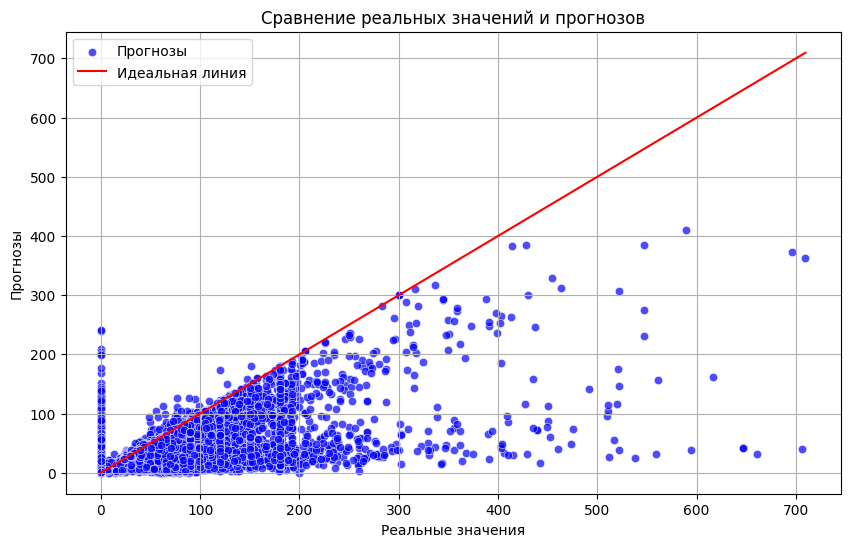

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Строим график для сравнения реальных значений и прогнозов
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.7, label="Прогнозы", color='blue')
sns.lineplot(x=y_val, y=y_val, color='red', label="Идеальная линия")
plt.title("Сравнение реальных значений и прогнозов")
plt.xlabel("Реальные значения")
plt.ylabel("Прогнозы")
plt.legend()
plt.grid(True)
plt.show()


По графику видно, что модель систематически занижает прогноз для более высоких значений целевой переменной. Чем больше реальное значение, тем сильнее недооценка. Модель хорошо предсказывает для значений, близких к нулю. Однако для низких значений есть выбросы, что говорит о наличии ошибок даже при небольших значениях. В области высоких реальных значений (например, больше 400) наблюдается значительное расхождение между предсказаниями и реальностью.
Это может говорить о том, что модель плохо справляется с редкими случаями высоких расходов. Возможно, следует нормализировать значения целевой переменной или использовать градиентный бустинг.

In [88]:

df_test['item_losses'] = y_test_pred


df_test.to_csv('df_test_with_predictions.csv', index=False)


from google.colab import files
files.download('df_test_with_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>